# Module 4: Exercises

This week's exercises examines different methods of collecting Twitter data in realtime. Before we start doing any specific tasks, load rtweet and the tidyverse.

In [1]:
library(rtweet)
suppressPackageStartupMessages(library(tidyverse))

### 1. Use the `statuses/sample` API to stream a "random sample" of tweets for 5 minutes.

In [2]:
st1 <- stream_tweets(timeout = 60 * 5)

Streaming tweets for 300 seconds...


Downloading: 2.7 MB       

Finished streaming tweets!
opening file input connection.


 Imported 1749 records. Simplifying...


closing file input connection.


### 2. Come up with your own method of exploiting the `statuses/filter/track` API to get as many tweets as indiscriminately as you can for 5 minutes.

In [3]:
## complete the code below
## I chose the top trending items from the time of my stream
qtrend <- "shaun white,#bachelorwintergames,#internetfriendsday,#blacklightning,#rexcomus,gold,michael cohen,#RHOBH,steven adams"

st2 <- stream_tweets(qtrend, timeout = 60 * 5)

Streaming tweets for 300 seconds...


Downloading: 6.7 MB       

Finished streaming tweets!
opening file input connection.


 Imported 3721 records. Simplifying...


closing file input connection.


### 3. Let's compare the two methods above with a generous query using `search_tweets()`.

In [4]:
st3 <- search_tweets(
    "lang:de OR lang:el OR lang:hi OR lang:ko OR lang:it OR lang:af OR lang:und OR lang:tr OR lang:ru OR lang:pt OR lang:ja OR lang:in OR lang:fr OR lang:es OR lang:en OR lang:ar",
    n = 13000)

Searching for tweets...
This may take a few seconds...
Finished collecting tweets!


### 4. Merge the tweets data with the users data for each of the 3 data sets gathered in 1-3.

In [5]:
## function to join
join_rtweet <- function(x) {
    users <- users_data(x)
    users <- users[, names(users) != "screen_name"]
    users <- users[!duplicated(users$user_id), ]
    dplyr::left_join(x, users, by = "user_id")
}

## merge tweets and users data for each
st1 <- join_rtweet(st1)
st2 <- join_rtweet(st2)
st3 <- join_rtweet(st3)

### 5. (a) Create a new variable named `stream_method` for each of the data sets. Using the strings `"statuses/sample"`, `"statuses/filter/track"`, and `"statuses/filter/locations"`, assign the values for the new variable in each data set appropriately. (b) Merge all three data sets into a single data set.

In [6]:
## create stream_method variable
st1$stream_method <- "statuses/sample"
st2$stream_method <- "statuses/filter/track"
st3$stream_method <- "statuses/filter/locations"
## bind by row all three data sets
st <- rbind(st1, st2, st3)

### 6. Extract the following features as numeric variables (use names in parentheses when provided):
+ is_retweet 
+ is_quote
+ is_reply (reply_to_status_id)
+ is_verified (verified)
+ tweet_chars (text)
+ bio_chars (description)
+ hashtags (hashtags),
+ mentions (mentions_user_id)
+ lang_en (lang)
+ lang_pt (lang)
+ lang_es (lang)
+ lang_ja (lang)
+ lang_other (lang)

Hint: use the function `count_elems()` defined below to count the number of hashtags, mentions, and media attachments.

In [7]:
## create function to count number of hashtags, media attachments, and mentions
count_elems <- function(x) {
    sapply(x, function(x) {
        ifelse(length(x) == 0L || (length(x) == 1L && is.na(x)), 
               0L, length(x))
    })
}

st_features <- st %>%
    mutate(
        account_created_at = as.numeric(account_created_at),
        ## I converted the account creation date to years from the oldest account's origin date
        account_created_at = (max(account_created_at) - account_created_at) / (60 * 60 * 24 * 365),
        is_retweet = as.integer(is_retweet),
        is_quote = as.integer(is_quote),
        is_reply = as.integer(!is.na(reply_to_status_id)),
        is_verified = as.integer(verified),
        tweet_chars = stringi::stri_width(text),
        bio_chars = ifelse(is.na(description), 0L, stringi::stri_width(description)),
        hashtags = count_elems(hashtags),
        mentions = count_elems(mentions_user_id),
        medias = count_elems(ext_media_url),
        lang_en = as.integer(lang == "en"),
        lang_pt = as.integer(lang == "pt"),
        lang_es = as.integer(lang == "es"),
        lang_ja = as.integer(lang == "ja"),
        lang_other = as.integer(!lang %in% c("en", "pt", "es", "ja"))) %>%
    mutate_if(is.integer, as.numeric) %>%
    select(stream_method, account_created_at, is_retweet, is_quote, is_reply,
           is_verified, tweet_chars, bio_chars, hashtags, mentions, medias, lang_en:lang_other)


### 7. Group by stream_method, summarise, and plot displaying the mean of each streaming method for each numeric variable.

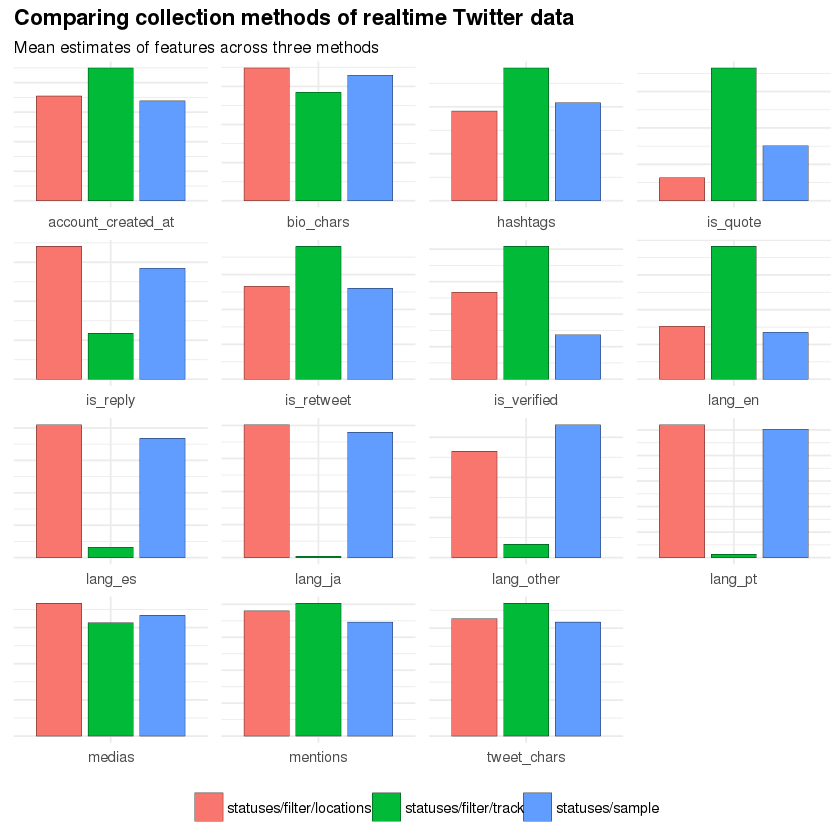

In [8]:
## group, summarise, and then plot
## group, summarise, and then plot
st_features %>%
    group_by(stream_method) %>%
    summarise_if(is.numeric, mean) %>%
    gather(var, mean, -stream_method) %>%
    ggplot(aes(x = var, y = mean, fill = stream_method)) + 
    geom_col(size = .1, colour = "black", width = .7, 
             position = position_dodge(width = .8)) + 
    theme_minimal() + 
    facet_wrap( ~ var, scales = "free", ncol = 4) + 
    theme(plot.title = element_text(face = "bold"),
          legend.position = "bottom", 
          axis.text.y = element_blank(),
          legend.title = element_blank(),
          strip.text = element_blank()) + 
    labs(title = "Comparing collection methods of realtime Twitter data",
        subtitle = "Mean estimates of features across three methods",
        x = NULL, y = NULL)

### 8. Based on the graphic you created in the previous step, which method would be best if the goal was to get a representative snapshot on Twitter? There is no wrong answer here. Briefly describe strengths and weaknesses of each and then make a judgment call.

> type your answer below - it should probably take you around 6-10 sentences


Unlike in the practice, I'll use process of elimination to find the best method this time. 

First, using the "trending" method is great for pulling hashtags, retweets, and quotes... but it's REALLY limited to English language tweets. So if you want a good representation of English language tweets, it's ideal... but since it eliminates such a large portion of all other tweets, it's out.

The other two methods look very similar in results--the random sample pulled more quoted tweets, but fewer replies. Random sampled slightly more hashtags, but fewer verified users. I think the verified user stat might be misleading--there are proportionately very few verified users compared to the overall number of users, so I think having a lower count there might not be so bad. I think that pushes me into thinking the random sample is best for a representative snapshot. It's well-balanced in many categories, as one would expect from a random sampling. 